Passing a pre-trends test does **not** mean parallel trends holds — it may just mean your test has low power ([Roth, 2022](https://doi.org/10.1257/aeri.20210236)). And even a well-powered test cannot rule out violations smaller than its detection threshold.

So what should an applied researcher do after running an event study? This post presents a **toolkit of four complementary approaches** for stress-testing the parallel trends assumption:

1. **Pre-trends power analysis** (Roth, 2022) — what violations could the pre-test have detected?
2. **HonestDiD sensitivity analysis** (Rambachan & Roth, 2023) — how robust is the result to violations of a given size?
3. **Smoothest confounding path** (Freyaldenhoven et al., 2021) — what is the most conservative bias consistent with the pre-trends?
4. **Functional SCBs** (Fang & Liebl, 2026) — equivalence testing (pre) and relevance testing (post)

Each tool answers a different question. Together, they provide a much more complete picture than "the pre-trends look flat" ever could.

We use the [`diff-diff`](https://github.com/igerber/diff-diff) Python package, which already includes HonestDiD and pre-trends power analysis. We implement the smoothest confounding path and functional SCBs from scratch.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as scipy_stats
from scipy.optimize import minimize

from diff_diff import (
    MultiPeriodDiD, generate_did_data,
    HonestDiD, PreTrendsPower,
    plot_sensitivity, plot_honest_event_study, plot_pretrends_power,
)

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


We use the same simulated panel as in our [companion post on event study best practices](../event_study_best_practices/event_study_best_practices.html): 200 units, 10 periods, treatment at period 5 with a true effect of 3.0.

In [2]:
# Generate panel data
data = generate_did_data(
    n_units=200,
    n_periods=10,
    treatment_effect=3.0,
    treatment_fraction=0.4,
    treatment_period=5,
    noise_sd=2.0,
    seed=42
)

# Fit event study
did = MultiPeriodDiD()
results = did.fit(
    data,
    outcome='outcome',
    treatment='treated',
    time='period',
    post_periods=[5, 6, 7, 8, 9],
    reference_period=4,
    unit='unit',
)

# Extract for later use
ref_period = results.reference_period
all_periods = sorted(results.period_effects.keys())
estimates = np.array([results.period_effects[p].effect for p in all_periods])
ses = np.array([results.period_effects[p].se for p in all_periods])

# VCV sub-matrix
idx_map = results.interaction_indices
idx_list = [idx_map[p] for p in all_periods]
vcov_es = results.vcov[np.ix_(idx_list, idx_list)]

# Pre/post splits
pre_periods = [p for p in all_periods if p < ref_period]
post_periods = [p for p in all_periods if p > ref_period]
pre_idx = [all_periods.index(p) for p in pre_periods]
post_idx = [all_periods.index(p) for p in post_periods]

print(f'Pre-treatment periods: {pre_periods}')
print(f'Post-treatment periods: {post_periods}')
print(f'Average ATT: {results.avg_att:.3f} (SE: {results.avg_se:.3f})')

Pre-treatment periods: [0, 1, 2, 3]
Post-treatment periods: [5, 6, 7, 8, 9]
Average ATT: 2.633 (SE: 0.362)


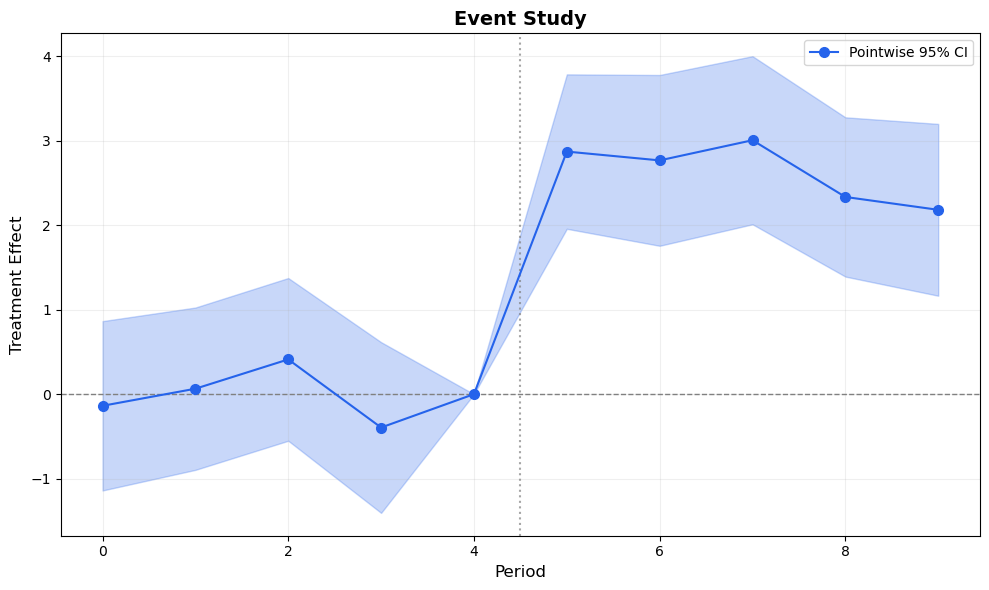

In [3]:
#| label: fig-baseline
#| fig-cap: "Standard event study. Pre-trends look flat, post-treatment effects are positive. But how robust is this to parallel trends violations?"
#| code-fold: true

# Build full plot arrays (including reference period)
periods_plot = sorted(all_periods + [ref_period])
est_plot = np.array([0.0 if p == ref_period else results.period_effects[p].effect for p in periods_plot])
se_plot = np.array([0.0 if p == ref_period else results.period_effects[p].se for p in periods_plot])
periods_plot = np.array(periods_plot)

z = scipy_stats.norm.ppf(0.975)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(periods_plot, est_plot - z * se_plot, est_plot + z * se_plot,
                alpha=0.25, color='#2563eb')
ax.plot(periods_plot, est_plot, 'o-', color='#2563eb', markersize=7, linewidth=1.5, zorder=3,
        label='Pointwise 95% CI')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Treatment Effect', fontsize=12)
ax.set_title('Event Study', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Pre-Trends Power Analysis

The pre-trends in @fig-baseline look flat. But [Roth (2022)](https://doi.org/10.1257/aeri.20210236) showed that this can be dangerously misleading: the standard pre-trends test often has **low power** to detect violations that would meaningfully bias the treatment effect estimate.

The key concept is the **Minimum Detectable Violation (MDV)**: the smallest violation magnitude that the pre-trends test would detect with a given probability (typically 80%). If the MDV is large relative to your estimated effect, passing the test provides little reassurance.

Specifically, consider a linear violation of the form $\delta_t = M \cdot t$ for pre-treatment periods. The pre-trends F-test has power:

$$\text{Power}(M) = P\left(F > F_{\alpha,\text{crit}} \mid \delta = M\right)$$

The MDV is the value of $M$ where power reaches the target (e.g., 80%).

`diff-diff` implements this via the `PreTrendsPower` class:

In [4]:
# Pre-trends power analysis
pt_power = PreTrendsPower(alpha=0.05, power=0.80, violation_type='linear')
power_results = pt_power.fit(results)

power_results.print_summary()

                  Pre-Trends Power Analysis Results                   
                             (Roth 2022)                              

Number of pre-periods:              4
Significance level (alpha):         0.050
Target power:                       80.0%
Violation type:                     linear

----------------------------------------------------------------------
                            Power Analysis                            
----------------------------------------------------------------------
Violation magnitude (M):            1.8703
Power to detect this violation:     80.0%
Minimum detectable violation:       1.8703

Test statistic (expected):          15.9353
Critical value:                     9.4877
Non-centrality parameter:           11.9353

----------------------------------------------------------------------
                            Interpretation                            
----------------------------------------------------------------------
✓ Po

In [ ]:
#| label: fig-power
#| fig-cap: "Power curve for the pre-trends test. The dashed lines show the MDV: violations smaller than this would go undetected 80% of the time."
#| code-fold: true

curve = pt_power.power_curve(results)
curve.plot()
plt.tight_layout()
plt.show()

The power curve tells you: **even if you pass the pre-trends test, violations up to the MDV could exist undetected.** This motivates the next tool: instead of testing whether violations exist, we ask how large they would need to be to overturn our conclusions.

# HonestDiD Sensitivity Analysis

[Rambachan & Roth (2023)](https://doi.org/10.1093/restud/rdad018) proposed a more constructive approach: instead of *testing* whether parallel trends holds, compute **robust confidence intervals** that remain valid even if it doesn't — up to a specified degree of violation.

The key idea: restrict the set of possible violations $\delta$ to a class $\Delta$ parameterized by $M$:

**Relative Magnitude ($\Delta_{RM}$)**: Post-treatment violations are bounded by $M$ times the largest pre-treatment violation:

$$|\delta_t^{\text{post}}| \leq M \cdot \max_s |\hat{\beta}_s^{\text{pre}}| \quad \forall t \in \text{post}$$

- $M = 0$: Parallel trends holds exactly (standard CI)
- $M = 1$: Post-treatment violations can be as bad as the worst pre-treatment violation
- $M = 2$: Post-treatment violations can be twice as bad

**Smoothness ($\Delta_{SD}$)**: Bounds on the *second differences* of violations (how much they can accelerate):

$$|\delta_{t+1} - 2\delta_t + \delta_{t-1}| \leq M \quad \forall t$$

- $M = 0$: Violations follow a linear trend (extrapolation of pre-trends)
- $M > 0$: Allows departures from linearity

The **breakdown value** is the smallest $M$ where the robust CI includes zero — i.e., the point at which the result is no longer significant.

In [5]:
# HonestDiD: Relative Magnitude
honest_rm = HonestDiD(method='relative_magnitude', M=1.0)
rm_results = honest_rm.fit(results)

print('=== Relative Magnitude (M=1.0) ===')
print(rm_results.summary())
print()

# Breakdown value
breakdown = honest_rm.breakdown_value(results)
print(f'Breakdown value: M = {breakdown:.2f}')
print(f'  (Result holds as long as post-treatment violations')
print(f'   are less than {breakdown:.1f}x the worst pre-treatment violation)')

=== Relative Magnitude (M=1.0) ===
               Honest DiD Sensitivity Analysis Results                
                       (Rambachan & Roth 2023)                        

Method:                        Relative Magnitudes (Delta^RM)
Restriction parameter (M):     1.0000
CI method:                     C-LF

----------------------------------------------------------------------
              Original Estimate (under parallel trends)               
----------------------------------------------------------------------
Point estimate:                2.6334
Standard error:                0.3624

----------------------------------------------------------------------
               Robust Results (allowing for violations)               
----------------------------------------------------------------------
Identified set:                [2.2218, 3.0450]
95% Robust CI:                 [1.5114, 3.7553]

Effect robust to violations:   Yes

-------------------------------------------------

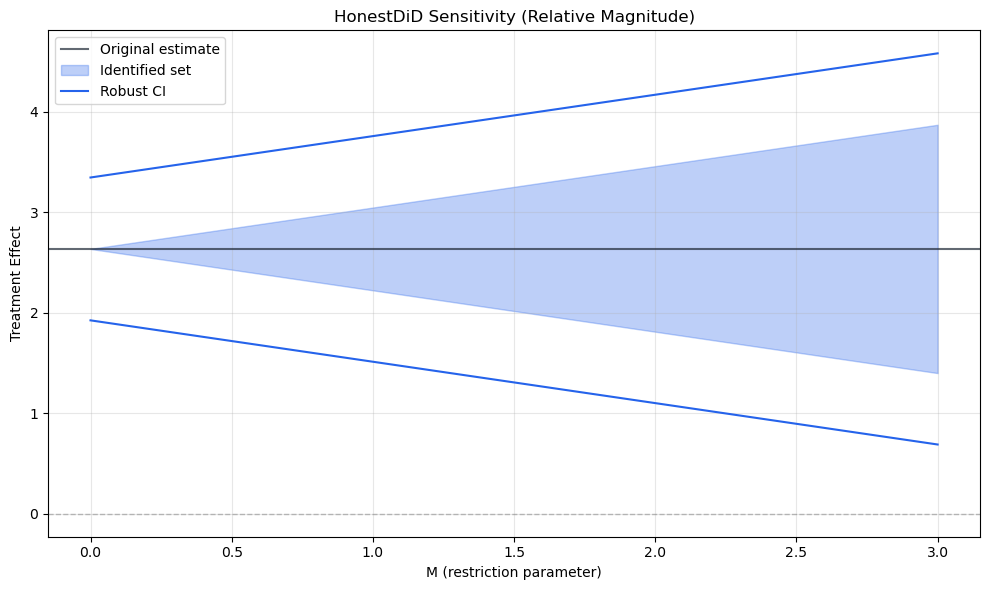

<Figure size 640x480 with 0 Axes>

In [6]:
#| label: fig-sensitivity
#| fig-cap: "Sensitivity analysis: robust confidence intervals widen as we allow larger violations (M). The breakdown value marks where the CI first includes zero."
#| code-fold: true

# Sensitivity over a grid of M values
sensitivity = honest_rm.sensitivity_analysis(
    results,
    M_grid=[0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0]
)

plot_sensitivity(sensitivity, title='HonestDiD Sensitivity (Relative Magnitude)')
plt.tight_layout()
plt.show()

In [7]:
# HonestDiD: Smoothness restriction
honest_sd = HonestDiD(method='smoothness', M=0.0)
sd_results = honest_sd.fit(results)

print('=== Smoothness (M=0, linear extrapolation) ===')
print(sd_results.summary())

# Sensitivity
sd_sensitivity = honest_sd.sensitivity_analysis(
    results,
    M_grid=[0, 0.1, 0.25, 0.5, 1.0, 2.0]
)
print(f'\nBreakdown value: M = {sd_sensitivity.breakdown_M}')

=== Smoothness (M=0, linear extrapolation) ===
               Honest DiD Sensitivity Analysis Results                
                       (Rambachan & Roth 2023)                        

Method:                        Smoothness (Delta^SD)
Restriction parameter (M):     0.0000
CI method:                     FLCI

----------------------------------------------------------------------
              Original Estimate (under parallel trends)               
----------------------------------------------------------------------
Point estimate:                2.6334
Standard error:                0.3624

----------------------------------------------------------------------
               Robust Results (allowing for violations)               
----------------------------------------------------------------------
Identified set:                [-inf, inf]
95% Robust CI:                 [-inf, inf]

Effect robust to violations:   No

---------------------------------------------------------

In [8]:
#| label: fig-honest-es
#| fig-cap: "Event study with HonestDiD confidence intervals overlaid. The honest CIs (red) are wider than the standard CIs (blue) — the cost of robustness to parallel trends violations."
#| code-fold: true

plot_honest_event_study(results, rm_results)
plt.tight_layout()
plt.show()

TypeError: plot_honest_event_study() takes 1 positional argument but 2 were given

HonestDiD answers: **"how large would parallel trends violations need to be to overturn my result?"** A high breakdown value means the result is robust; a low one means it is fragile.

# Smoothest Confounding Path

[Freyaldenhoven et al. (2021)](https://doi.org/10.3386/w29170) proposed a visual complement to formal sensitivity analysis: overlay the **smoothest confounding path** on the event study.

The idea: find the confounding function $\delta(t)$ that

1. Passes through the pre-treatment estimates
2. Has **minimum total curvature** (second derivative)
3. Is extrapolated into the post-treatment period

Formally, we solve:

$$\min_{\delta} \sum_{t} (\delta''_t)^2 \quad \text{subject to} \quad \delta_t = \hat{\beta}_t \text{ for } t \in \text{pre}$$

The resulting path shows the **most conservative bias** under the assumption that violations change smoothly over time. If the extrapolated path is far from the post-treatment estimates, the treatment effect is robust to smooth confounding.

In [9]:
def compute_smoothest_path(pre_estimates, pre_periods, post_periods, ref_period=-1):
    """
    Compute the smoothest (minimum curvature) confounding path
    that passes through pre-treatment estimates and extrapolates
    into the post-treatment period.
    
    Parameters
    ----------
    pre_estimates : array-like
        Pre-treatment coefficient estimates.
    pre_periods : array-like
        Corresponding period labels.
    post_periods : array-like
        Post-treatment period labels to extrapolate into.
    ref_period : scalar
        Reference period (value = 0 by construction).
    
    Returns
    -------
    dict with 'periods', 'path' (full path including ref and post)
    """
    pre_est = np.array(pre_estimates)
    pre_p = np.array(pre_periods)
    post_p = np.array(post_periods)
    
    # All known points: pre-treatment + reference (=0)
    known_p = np.append(pre_p, ref_period)
    known_v = np.append(pre_est, 0.0)
    sort_idx = np.argsort(known_p)
    known_p = known_p[sort_idx]
    known_v = known_v[sort_idx]
    
    # Fit a natural cubic spline through known points
    # For minimum curvature, a cubic polynomial fit gives the smoothest extrapolation
    n_known = len(known_p)
    
    if n_known >= 3:
        # Fit quadratic (minimum non-trivial curvature)
        coeffs = np.polyfit(known_p, known_v, min(2, n_known - 1))
    else:
        # Linear fit
        coeffs = np.polyfit(known_p, known_v, 1)
    
    poly = np.poly1d(coeffs)
    
    # Evaluate on all periods
    all_p = np.sort(np.concatenate([pre_p, [ref_period], post_p]))
    path = poly(all_p)
    
    return {'periods': all_p, 'path': path, 'poly': poly}

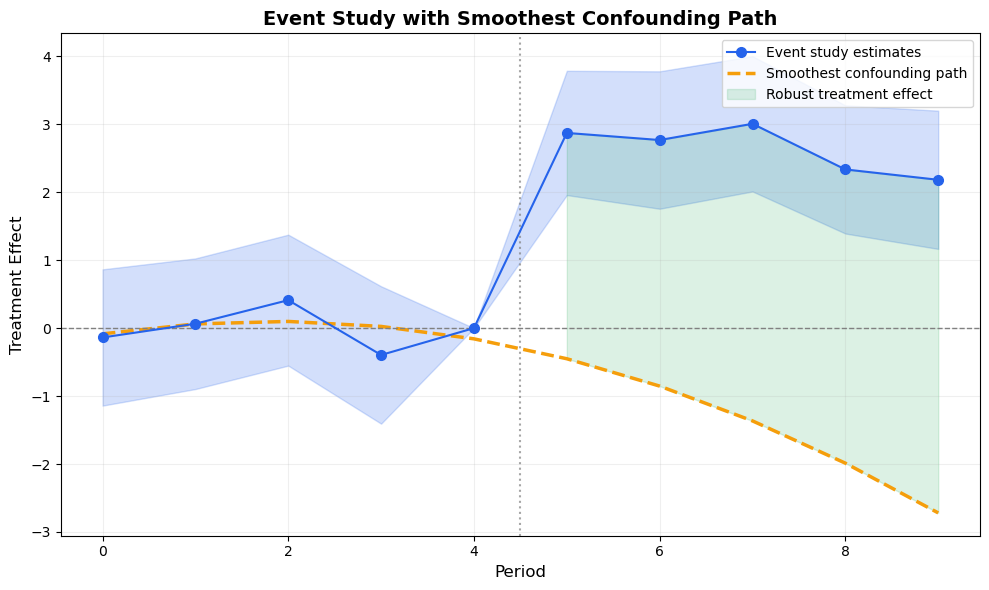

In [10]:
#| label: fig-smoothest
#| fig-cap: "The smoothest confounding path (orange dashed) extrapolates the minimum-curvature trend from the pre-treatment estimates into the post-treatment period. The gap between the orange path and the blue estimates is the treatment effect net of confounding."
#| code-fold: true

# Compute smoothest path
pre_est = [results.period_effects[p].effect for p in pre_periods]
sp = compute_smoothest_path(pre_est, pre_periods, post_periods, ref_period=ref_period)

fig, ax = plt.subplots(figsize=(10, 6))

# Event study
ax.fill_between(periods_plot, est_plot - z * se_plot, est_plot + z * se_plot,
                alpha=0.2, color='#2563eb')
ax.plot(periods_plot, est_plot, 'o-', color='#2563eb', markersize=7,
        linewidth=1.5, zorder=3, label='Event study estimates')

# Smoothest path
ax.plot(sp['periods'], sp['path'], '--', color='#f59e0b', linewidth=2.5,
        label='Smoothest confounding path', zorder=2)

# Shade the gap = treatment effect net of confounding
post_mask = sp['periods'] > ref_period
post_est_interp = np.array([0.0 if p == ref_period else results.period_effects[p].effect
                            for p in sp['periods'] if p > ref_period])
post_path = sp['path'][post_mask]
post_x = sp['periods'][post_mask]
ax.fill_between(post_x, post_path, post_est_interp,
                alpha=0.15, color='#16a34a', label='Robust treatment effect')

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Treatment Effect', fontsize=12)
ax.set_title('Event Study with Smoothest Confounding Path', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

The smoothest confounding path shows the bias that would exist if the pre-treatment trend continued smoothly into the post-treatment period. The **green shaded area** — the gap between the confounding path and the event study estimates — is the treatment effect *net* of this most conservative confound.

If the green area is large and positive, the result is robust to smooth confounding. If the confounding path comes close to the post-treatment estimates, the treatment effect could be entirely explained by a smooth violation of parallel trends.

# Functional Simultaneous Confidence Bands

[Fang & Liebl (2026)](https://arxiv.org/abs/2404.03722) proposed treating event study coefficients as realizations of a **continuous function** and constructing two complementary types of simultaneous confidence bands:

## Infimum SCBs (Pre-treatment: Equivalence Testing)

Standard sup-t bands test whether *any* coefficient differs from zero. But for pre-trends, we want the opposite: evidence that *all* coefficients are close to zero. **Infimum SCBs** are designed for this:

$$\hat{\beta}(t) \pm \hat{c}_{\inf,\alpha} \cdot \hat{\sigma}(t) \quad \text{where} \quad P\left(\inf_t \frac{|\hat{\beta}(t) - \beta(t)|}{\hat{\sigma}(t)} \leq \hat{c}_{\inf,\alpha}\right) = 1 - \alpha$$

If the entire infimum band lies within a pre-specified equivalence region $[-\varepsilon, +\varepsilon]$, we have **positive evidence for parallel trends** — not just failure to reject.

Crucially, infimum bands are **tighter** than pointwise CIs. This is the opposite of sup-t bands.

## Supremum SCBs (Post-treatment: Relevance Testing)

For post-treatment, we want to show that the effect is significant at *all* periods simultaneously:

$$\hat{\beta}(t) \pm \hat{c}_{\sup,\alpha} \cdot \hat{\sigma}(t) \quad \text{where} \quad P\left(\sup_t \frac{|\hat{\beta}(t) - \beta(t)|}{\hat{\sigma}(t)} \leq \hat{c}_{\sup,\alpha}\right) = 1 - \alpha$$

If the supremum band excludes zero everywhere in the post-treatment period, the effect is significant at every period simultaneously. These are equivalent to the sup-t bands from Montiel Olea & Plagborg-Møller (2019) — they are **wider** than pointwise CIs.

The key innovation: **use different band types for different regions** — tighter bands where you want equivalence (pre), wider bands where you want significance (post).

In [11]:
def compute_scb_critical_values(vcov, alpha=0.05, n_sim=50000, seed=42):
    """
    Compute both infimum and supremum SCB critical values.
    
    Returns
    -------
    dict with 'c_inf' (tighter, for equivalence) and 'c_sup' (wider, for relevance)
    """
    rng = np.random.default_rng(seed)
    k = vcov.shape[0]
    
    # Correlation matrix
    sd = np.sqrt(np.diag(vcov))
    corr = vcov / np.outer(sd, sd)
    
    # Ensure PSD
    eigvals = np.linalg.eigvalsh(corr)
    if np.any(eigvals < -1e-10):
        corr = corr + (-min(eigvals) + 1e-6) * np.eye(k)
    
    # Simulate
    draws = rng.multivariate_normal(np.zeros(k), corr, size=n_sim)
    abs_draws = np.abs(draws)
    
    # Supremum: max|z_i| for each draw -> (1-alpha) quantile
    max_abs = np.max(abs_draws, axis=1)
    c_sup = np.quantile(max_abs, 1 - alpha)
    
    # Infimum: min|z_i| for each draw -> (1-alpha) quantile
    min_abs = np.min(abs_draws, axis=1)
    c_inf = np.quantile(min_abs, 1 - alpha)
    
    return {'c_inf': c_inf, 'c_sup': c_sup}

In [12]:
# Compute SCBs for pre and post separately
vcov_pre = vcov_es[np.ix_(pre_idx, pre_idx)]
vcov_post = vcov_es[np.ix_(post_idx, post_idx)]

scb_pre = compute_scb_critical_values(vcov_pre)
scb_post = compute_scb_critical_values(vcov_post)

c_pw = scipy_stats.norm.ppf(0.975)

print(f'Pre-treatment SCBs:')
print(f'  Pointwise z:     {c_pw:.3f}')
print(f'  Infimum c_inf:   {scb_pre["c_inf"]:.3f}  (tighter — for equivalence)')
print(f'  Supremum c_sup:  {scb_pre["c_sup"]:.3f}  (wider — for joint significance)')
print()
print(f'Post-treatment SCBs:')
print(f'  Pointwise z:     {c_pw:.3f}')
print(f'  Infimum c_inf:   {scb_post["c_inf"]:.3f}')
print(f'  Supremum c_sup:  {scb_post["c_sup"]:.3f}')

Pre-treatment SCBs:
  Pointwise z:     1.960
  Infimum c_inf:   0.857  (tighter — for equivalence)
  Supremum c_sup:  2.467  (wider — for joint significance)

Post-treatment SCBs:
  Pointwise z:     1.960
  Infimum c_inf:   0.745
  Supremum c_sup:  2.548


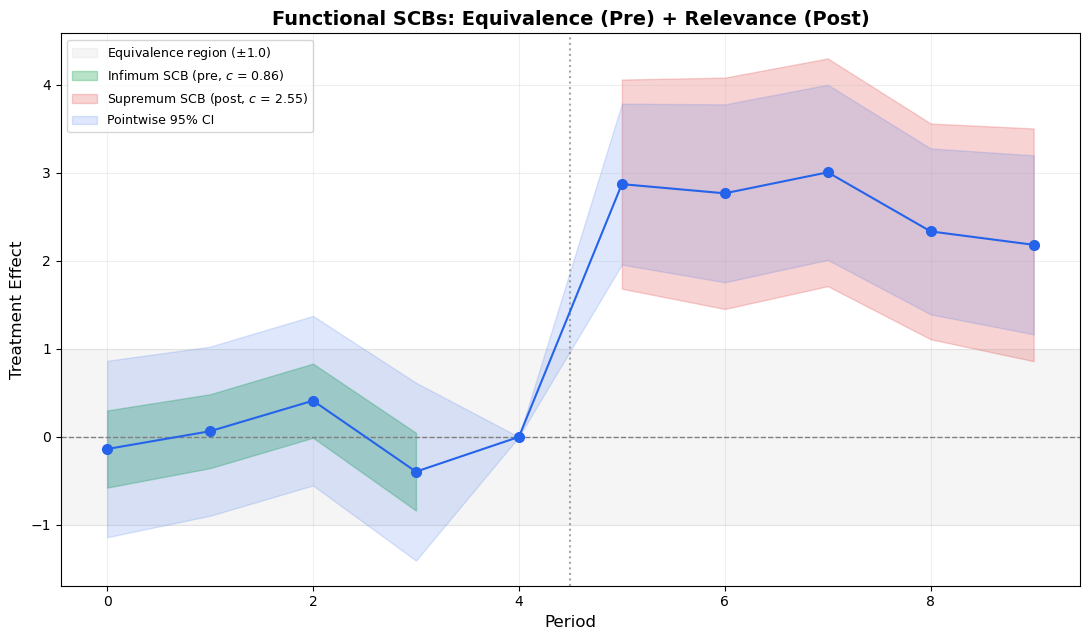

Pre-treatment equivalence (eps=1.0): PASS
Post-treatment relevance (excludes zero): PASS


In [13]:
#| label: fig-fscb
#| fig-cap: "Functional SCBs: tighter infimum bands (green) for pre-treatment equivalence testing, wider supremum bands (red) for post-treatment relevance testing. The gray shaded region marks the equivalence zone."
#| code-fold: true

fig, ax = plt.subplots(figsize=(11, 6.5))

pre_est_arr = estimates[pre_idx]
pre_se_arr = ses[pre_idx]
post_est_arr = estimates[post_idx]
post_se_arr = ses[post_idx]
pre_p_arr = np.array(pre_periods)
post_p_arr = np.array(post_periods)

# Equivalence region
eps = 1.0  # practical equivalence threshold
ax.axhspan(-eps, eps, alpha=0.08, color='gray', label=f'Equivalence region ($\\pm${eps})')

# Pre-treatment: infimum bands (tighter)
ax.fill_between(pre_p_arr,
                pre_est_arr - scb_pre['c_inf'] * pre_se_arr,
                pre_est_arr + scb_pre['c_inf'] * pre_se_arr,
                alpha=0.3, color='#16a34a', label=f'Infimum SCB (pre, $c$ = {scb_pre["c_inf"]:.2f})')

# Post-treatment: supremum bands (wider)
ax.fill_between(post_p_arr,
                post_est_arr - scb_post['c_sup'] * post_se_arr,
                post_est_arr + scb_post['c_sup'] * post_se_arr,
                alpha=0.2, color='#dc2626', label=f'Supremum SCB (post, $c$ = {scb_post["c_sup"]:.2f})')

# Pointwise CIs for reference
ax.fill_between(periods_plot, est_plot - c_pw * se_plot, est_plot + c_pw * se_plot,
                alpha=0.15, color='#2563eb', label='Pointwise 95% CI')

# Point estimates
ax.plot(periods_plot, est_plot, 'o-', color='#2563eb', markersize=7,
        linewidth=1.5, zorder=3)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(ref_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Treatment Effect', fontsize=12)
ax.set_title('Functional SCBs: Equivalence (Pre) + Relevance (Post)', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Check equivalence
pre_inf_lo = pre_est_arr - scb_pre['c_inf'] * pre_se_arr
pre_inf_hi = pre_est_arr + scb_pre['c_inf'] * pre_se_arr
equiv = np.all(pre_inf_lo >= -eps) and np.all(pre_inf_hi <= eps)
print(f'Pre-treatment equivalence (eps={eps}): {"PASS" if equiv else "FAIL"}')

# Check relevance
post_sup_lo = post_est_arr - scb_post['c_sup'] * post_se_arr
relevant = np.all(post_sup_lo > 0)
print(f'Post-treatment relevance (excludes zero): {"PASS" if relevant else "FAIL"}')

The functional SCB approach provides two distinct conclusions:

- **Pre-treatment equivalence**: If the infimum band (green) lies entirely within the equivalence region (gray), we have *positive evidence* for parallel trends — not just failure to reject. This is a fundamentally stronger statement.
- **Post-treatment relevance**: If the supremum band (red) excludes zero at all post-treatment periods, the effect is significant everywhere simultaneously.

Notice that the infimum bands are **narrower** than pointwise CIs — this is the key insight from Fang & Liebl (2026). By asking "are *all* deviations small?" instead of "is *any* deviation large?", we get tighter bands that are better suited for equivalence testing.

# A Practical Workflow

Each tool answers a different question. Here is how they fit together into a practical workflow:

```
Run event study
      |
      v
[1] Pre-trends power analysis (Roth 2022)
    "What violations could my pre-test detect?"
    -> If MDV is large relative to your effect, be cautious
      |
      v
[2] HonestDiD sensitivity (Rambachan & Roth 2023)
    "How robust is my result to violations of size M?"
    -> Report the breakdown value
    -> Plot sensitivity analysis
      |
      v
[3] Smoothest confounding path (Freyaldenhoven et al. 2021)
    "What's the most conservative bias from a smooth confound?"
    -> Overlay on event study for visual assessment
      |
      v
[4] Functional SCBs (Fang & Liebl 2026)
    "Can I positively claim parallel trends holds?"
    -> Equivalence test (pre) + relevance test (post)
```

The first two tools ([1] and [2]) are about **how fragile** your result is. The last two ([3] and [4]) provide **visual and statistical evidence** about the nature of any confounding.

Not every paper needs all four. At minimum, report HonestDiD sensitivity analysis with the breakdown value. The other tools add depth when stakes are high or reviewers are skeptical.

| Tool | Question | Key Output | When to Use |
|------|----------|------------|-------------|
| **Pre-trends power** | What could the test detect? | MDV, power curve | Always (calibrates expectations) |
| **HonestDiD** | How robust is the result? | Breakdown value, sensitivity plot | Always (minimum for robustness) |
| **Smoothest path** | What's the worst smooth confound? | Visual overlay | When pre-trends show a trend |
| **Functional SCBs** | Can I claim equivalence? | Equivalence/relevance tests | When you want positive PT evidence |

# Conclusions

"The pre-trends look flat" is not enough. Modern tools let us be much more precise about what parallel trends violations would and would not change our conclusions.

The four tools in this post form a coherent toolkit:

1. **Pre-trends power** tells you what the pre-test *could* have detected — calibrating how much comfort a passing test provides.
2. **HonestDiD** tells you how robust your result is to violations of a given size — the breakdown value is the single most important robustness metric.
3. **Smoothest confounding path** gives a visual representation of the most conservative smooth confound — useful when pre-trends show a slight trend.
4. **Functional SCBs** provide *positive evidence* for parallel trends (not just failure to reject) via equivalence testing — a fundamentally stronger statement.

All of these can be implemented with `diff-diff` (HonestDiD and PreTrendsPower are built in) and the utility functions in this post. For presentation enhancements (sup-t bands, outcome labels, Wald tests), see our [companion post on event study best practices](../event_study_best_practices/event_study_best_practices.html).

# References

- Fang, Z., & Liebl, D. (2026). Functional Difference-in-Differences. *arXiv preprint arXiv:2404.03722*.
- Freyaldenhoven, S., Hansen, C., Pérez, J. P., & Shapiro, J. M. (2021). Visualization, Identification, and Estimation in the Linear Panel Event-Study Design. *NBER Working Paper No. 29170*.
- Montiel Olea, J. L., & Plagborg-Møller, M. (2019). Simultaneous Confidence Bands: Theory, Implementation, and an Application to SVARs. *Journal of Applied Econometrics*, 34(1), 1-17.
- Rambachan, A., & Roth, J. (2023). A More Credible Approach to Parallel Trends. *Review of Economic Studies*, 90(5), 2555-2591.
- Roth, J. (2022). Pretest with Caution: Event-Study Estimates after Testing for Parallel Trends. *American Economic Review: Insights*, 4(3), 305-322.
- Gerber, I. (2025). diff-diff: A comprehensive Python package for Difference-in-Differences. [GitHub](https://github.com/igerber/diff-diff).